In [1]:
 # Importing required libraries

import pandas as pd
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from matplotlib import image as im
import matplotlib.pyplot as plt
from ipywidgets import interact
import pydicom as pyd
import copy as cp
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import models
# from keras.models import load_model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [3]:
# Loading the dataset

data = pd.read_csv("C:/Users/tharu/OneDrive/Documents/Capstone/jupyter/dataset - New.csv")
print("No. of columns in the dataset: ", data.shape[1])
print("No. of rows in the dataset: ", data.shape[0])

No. of columns in the dataset:  7
No. of rows in the dataset:  240


In [4]:
data.head()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax
0,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_1.dcm,858,362,1733,556
1,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_10.dcm,764,423,2414,581
2,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_11.dcm,3,462,2278,652
3,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_12.dcm,1147,439,2466,564
4,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_13.dcm,849,368,1758,579


In [5]:
data.tail()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax
235,./Leaf smut/Leaf_smut_6.jpg,Leaf smut,./segmented-ls/Leaf_smut_6.dcm,1272,358,2360,595
236,./Leaf smut/Leaf_smut_60.jpg,Leaf smut,./segmented-ls/Leaf_smut_60.dcm,227,313,2447,679
237,./Leaf smut/Leaf_smut_7.jpg,Leaf smut,./segmented-ls/Leaf_smut_7.dcm,356,349,2812,727
238,./Leaf smut/Leaf_smut_8.jpg,Leaf smut,./segmented-ls/Leaf_smut_8.dcm,266,139,2845,679
239,./Leaf smut/Leaf_smut_9.jpg,Leaf smut,./segmented-ls/Leaf_smut_9.dcm,310,366,1260,695


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
Images          240 non-null object
Disease         240 non-null object
Dicom Images    240 non-null object
Xmin            240 non-null object
Ymin            240 non-null object
Xmax            240 non-null object
Ymax            240 non-null object
dtypes: object(7)
memory usage: 13.2+ KB


In [7]:
# Exploratory data analysis

data_na = (data.isnull().sum()*100)/len(data)
print("% of missing data in each feature:")
data_na.sort_values(ascending=False)

% of missing data in each feature:


Ymax            0.0
Xmax            0.0
Ymin            0.0
Xmin            0.0
Dicom Images    0.0
Disease         0.0
Images          0.0
dtype: float64

In [8]:
data['Disease'].value_counts()

Healthy leaf             60
Leaf smut                60
Brown spot               60
Bacterial leaf blight    60
Name: Disease, dtype: int64

In [9]:
data[data.Disease=="Healthy leaf"].head()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax
120,./Healthy leaf/Healthy_leaf_1.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_1.dcm,?,?,?,?
121,./Healthy leaf/Healthy_leaf_10.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_10.dcm,?,?,?,?
122,./Healthy leaf/Healthy_leaf_11.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_11.dcm,?,?,?,?
123,./Healthy leaf/Healthy_leaf_12.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_12.dcm,?,?,?,?
124,./Healthy leaf/Healthy_leaf_13.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_13.dcm,?,?,?,?


In [10]:
data['Xmax'][data.Disease=='Healthy leaf'] = 0
data['Ymax'][data.Disease=='Healthy leaf'] = 0
data['Xmin'][data.Disease=='Healthy leaf'] = 0
data['Ymin'][data.Disease=='Healthy leaf'] = 0

data.Xmax = data.Xmax.astype("int64")
data.Ymax = data.Ymax.astype("int64")
data.Xmin = data.Xmin.astype("int64")
data.Ymin = data.Ymin.astype("int64")

In [11]:
# Performing one-hot encoding

df = cp.deepcopy(data)
df['Disease'] = df['Disease'].astype('category')
dummies = pd.get_dummies(df['Disease'],prefix='Disease')
df = pd.concat([df, dummies], axis=1)

In [12]:
# Data engineering -> creating new features in the dataset

for i in range(len(df)):
    if df['Disease'][i]=='Healthy leaf':
        df['object_present'] = 0
    else:
        df['object_present'] = 1

In [13]:
width, height = [], []

for i in range(len(df)):
    img = im.imread(df.Images[i])
    width.append(img.shape[0])
    height.append(img.shape[1])
    
df['Image_width'] = width
df['Image_height'] = height

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 14 columns):
Images                           240 non-null object
Disease                          240 non-null category
Dicom Images                     240 non-null object
Xmin                             240 non-null int64
Ymin                             240 non-null int64
Xmax                             240 non-null int64
Ymax                             240 non-null int64
Disease_Bacterial leaf blight    240 non-null uint8
Disease_Brown spot               240 non-null uint8
Disease_Healthy leaf             240 non-null uint8
Disease_Leaf smut                240 non-null uint8
object_present                   240 non-null int64
Image_width                      240 non-null int64
Image_height                     240 non-null int64
dtypes: category(1), int64(7), object(2), uint8(4)
memory usage: 18.3+ KB


In [15]:
df

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax,Disease_Bacterial leaf blight,Disease_Brown spot,Disease_Healthy leaf,Disease_Leaf smut,object_present,Image_width,Image_height
0,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_1.dcm,858,362,1733,556,1,0,0,0,1,897,3081
1,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_10.dcm,764,423,2414,581,1,0,0,0,1,897,3081
2,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_11.dcm,3,462,2278,652,1,0,0,0,1,897,3081
3,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_12.dcm,1147,439,2466,564,1,0,0,0,1,897,3081
4,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_13.dcm,849,368,1758,579,1,0,0,0,1,897,3081
5,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_14.dcm,1247,339,3049,566,1,0,0,0,1,897,3081
6,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_15.dcm,272,362,2639,487,1,0,0,0,1,897,3081
7,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_16.dcm,585,320,2653,502,1,0,0,0,1,897,3081
8,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_17.dcm,1145,450,2474,550,1,0,0,0,1,897,3081
9,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_18.dcm,789,402,2564,570,1,0,0,0,1,897,3081


In [16]:
# Visualizing original image 

@interact(i=(0,len(df)-1))
def openfile(i):
    data = im.imread(df.Images[i])
    print(df.Disease[i])
    
    # summarize shape of the pixel array
    print(data.dtype)
    print(data.shape)
    print(type(data))
    
    start_point = (df.Xmin[i], df.Ymin[i])    # (xmin, ymin)
    end_point = (df.Xmax[i], df.Ymax[i])      # (xmax, ymax)
    color = (255, 0, 0)                       # RGB
    thickness = 2
    data = cv2.rectangle(data, start_point, end_point, color, thickness)
    
    # display the array of pixels as an image
    plt.imshow(data)
    plt.show()

interactive(children=(IntSlider(value=119, description='i', max=239), Output()), _dom_classes=('widget-interac…

In [17]:
# Visualizing segmented image

@interact(i=(0,len(df)-1))
def openfile(i):
    image_path = df["Dicom Images"][i]
    ds = pyd.dcmread(image_path)
    print(ds)
    plt.imshow(ds.pixel_array)
    plt.show()

interactive(children=(IntSlider(value=119, description='i', max=239), Output()), _dom_classes=('widget-interac…

In [18]:
# Splitting the dataset into train and test

ratio = int(0.8 * df.shape[0])
indices = np.random.permutation(df.shape[0])
training_idx, test_idx = indices[:ratio], indices[ratio:]
train, test = df.iloc[training_idx,:], df.iloc[test_idx,:]

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [19]:
train.head()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax,Disease_Bacterial leaf blight,Disease_Brown spot,Disease_Healthy leaf,Disease_Leaf smut,object_present,Image_width,Image_height
0,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_19.dcm,831,420,1487,533,1,0,0,0,1,897,3081
1,./Brown spot/Brown_spot_34.jpg,Brown spot,./segmented-bs/Brown_spot_34.dcm,848,350,2281,602,0,1,0,0,1,897,3081
2,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_53.dcm,787,238,1949,380,1,0,0,0,1,897,3081
3,./Leaf smut/Leaf_smut_52.jpg,Leaf smut,./segmented-ls/Leaf_smut_52.dcm,13,31,634,212,0,0,0,1,1,291,741
4,./Healthy leaf/Healthy_leaf_4.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_4.dcm,0,0,0,0,0,0,1,0,1,2661,551


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 14 columns):
Images                           192 non-null object
Disease                          192 non-null category
Dicom Images                     192 non-null object
Xmin                             192 non-null int64
Ymin                             192 non-null int64
Xmax                             192 non-null int64
Ymax                             192 non-null int64
Disease_Bacterial leaf blight    192 non-null uint8
Disease_Brown spot               192 non-null uint8
Disease_Healthy leaf             192 non-null uint8
Disease_Leaf smut                192 non-null uint8
object_present                   192 non-null int64
Image_width                      192 non-null int64
Image_height                     192 non-null int64
dtypes: category(1), int64(7), object(2), uint8(4)
memory usage: 14.7+ KB


In [21]:
test.head()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax,Disease_Bacterial leaf blight,Disease_Brown spot,Disease_Healthy leaf,Disease_Leaf smut,object_present,Image_width,Image_height
0,./Brown spot/Brown_spot_41.jpg,Brown spot,./segmented-bs/Brown_spot_41.dcm,4,6,726,136,0,1,0,0,1,224,765
1,./Leaf smut/Leaf_smut_27.jpg,Leaf smut,./segmented-ls/Leaf_smut_27.dcm,416,314,1964,562,0,0,0,1,1,897,3081
2,./Leaf smut/Leaf_smut_56.jpg,Leaf smut,./segmented-ls/Leaf_smut_56.dcm,246,322,2465,684,0,0,0,1,1,897,3081
3,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_14.dcm,1247,339,3049,566,1,0,0,0,1,897,3081
4,./Leaf smut/Leaf_smut_50.jpg,Leaf smut,./segmented-ls/Leaf_smut_50.dcm,30,45,446,142,0,0,0,1,1,233,565


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 14 columns):
Images                           48 non-null object
Disease                          48 non-null category
Dicom Images                     48 non-null object
Xmin                             48 non-null int64
Ymin                             48 non-null int64
Xmax                             48 non-null int64
Ymax                             48 non-null int64
Disease_Bacterial leaf blight    48 non-null uint8
Disease_Brown spot               48 non-null uint8
Disease_Healthy leaf             48 non-null uint8
Disease_Leaf smut                48 non-null uint8
object_present                   48 non-null int64
Image_width                      48 non-null int64
Image_height                     48 non-null int64
dtypes: category(1), int64(7), object(2), uint8(4)
memory usage: 3.9+ KB


In [23]:
# Function to normalize bounding box coordinates (PASCAL VOC format)

def normalize(size, box): # box -> (xmin, xmax, ymin, ymax)
    w = size[0]
    h = size[1]
    x1 = box[0] / w
    x2 = box[1] / w
    y1 = box[2] / h
    y2 = box[3] / h
    return (x1, y1, x2, y2)

In [24]:
# Preparing training dataset labels for input

labels = np.zeros(shape = (len(train), 4))
sizes = np.zeros(shape = (len(train), 2))
classes = np.zeros(shape = (len(train), 4))

for i in range(len(train)):
    size = (train['Image_width'][i], train['Image_height'][i])
    box = (train['Xmin'][i], train['Xmax'][i], train['Ymin'][i], train['Ymax'][i])
    bb = normalize(size, box) 
    labels[i] = [bb[0], bb[1], bb[2], bb[3]]
    classes[i] = [train['Disease_Bacterial leaf blight'][i], train['Disease_Brown spot'][i], train['Disease_Healthy leaf'][i], train['Disease_Leaf smut'][i]]
    sizes[i] = [size[0], size[1]]

In [25]:
print(np.shape(labels))
labels

(192, 4)


array([[9.26421405e-01, 1.36319377e-01, 1.65774805e+00, 1.72995781e-01],
       [9.45373467e-01, 1.13599481e-01, 2.54292085e+00, 1.95391107e-01],
       [8.77369008e-01, 7.72476469e-02, 2.17279822e+00, 1.23336579e-01],
       [4.46735395e-02, 4.18353576e-02, 2.17869416e+00, 2.86099865e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.32775920e-01, 1.15546900e-01, 2.75808250e+00, 2.22330412e-01],
       [2.75362319e-01, 5.16066212e-02, 2.38907469e+00, 2.04479065e-01],
       [1.18677043e-01, 2.35677083e-01, 1.47276265e+00, 4.97395833e-01],
       [2.50000000e-01, 2.65957447e-03, 4.22500000e+00, 1.99468085e-01],
       [1.61725067e-01, 9.73856209e-02, 4.02964960e+00, 2.42483660e-01],
       [6.42140468e-01, 9.31515742e-02, 2.71237458e+00, 2.04479065e-01],
       [3.96878484e-01, 6.13437196e-02, 2.65105909e+00, 2.05452775e-01],
       [5.40229885e-01, 1.51093439e-01, 2.09195402e+00, 3.30019881e-01],
       [6.22222222e-02, 2.32500000e-01, 1.15111111e

In [26]:
print(np.shape(sizes))
sizes

(192, 2)


array([[ 897., 3081.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 291.,  741.],
       [2661.,  551.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 514.,  768.],
       [  80.,  376.],
       [ 371., 1530.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 174.,  503.],
       [ 900., 1200.],
       [ 897., 3081.],
       [ 224.,  765.],
       [ 897., 3081.],
       [2448., 2448.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 200.,  250.],
       [ 551., 2661.],
       [2645., 2645.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 104.,  467.],
       [1847., 1847.],
       [ 174.,  503.],
       [ 897., 3081.],
       [  73.,  367.],
       [2169., 2169.],
       [ 897., 3081.],
       [1285., 1828.],
       [ 900., 1200.],
       [ 281., 1280.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 470., 2485.],
       [  71.,  301.],
       [ 676., 1244.],
       [  92.,  286.],
       [ 900., 1200.],
       [ 85

In [27]:
print(np.shape(classes))
classes

(192, 4)


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],


In [28]:
# Preparing test dataset labels for evaluation

val_labels = np.zeros(shape = (len(test), 4))
val_sizes = np.zeros(shape = (len(test), 2))
val_classes = np.zeros(shape = (len(test), 4))

for i in range(len(test)):
    size = (test['Image_width'][i], test['Image_height'][i])
    box = (test['Xmin'][i], test['Xmax'][i], test['Ymin'][i], test['Ymax'][i])
    bb = normalize(size, box) 
    val_labels[i] = [bb[0], bb[1], bb[2], bb[3]]
    val_classes[i] = [test['Disease_Bacterial leaf blight'][i], test['Disease_Brown spot'][i], test['Disease_Healthy leaf'][i], test['Disease_Leaf smut'][i]]
    val_sizes[i] = [size[0], size[1]]

In [29]:
# Loading the pre-trained model


model = ResNet50(weights='imagenet',include_top=False)


In [30]:
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [31]:
# Variable initialisation for model training

train_feature = np.zeros(shape = (len(train), 7, 7, 2048)) # Last layer of ResNet50 has a shape of 7 x 7 x 2048
traindcm_feature = np.zeros(shape = (len(train), 7, 7, 2048))

In [32]:
# Feature extraction of original image

for i in range(len(train)):
    img_path = train.Images[i]
    img = cv2.imread(img_path)
    img_data = cv2.resize(img, (224,224))
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    resnet50_feature = model.predict(img_data)
    train_feature[i] = resnet50_feature

In [33]:
# Feature extraction of segmented image

for i in range(len(train)):
    image_path = train["Dicom Images"][i]
    ds = pyd.dcmread(image_path)
    img = ds.pixel_array
    img_data = cv2.resize(img, (224,224))
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    resnet50_dcmfeature = model.predict(img_data)
    traindcm_feature[i] = resnet50_dcmfeature

In [34]:
train_features_vec = np.reshape(train_feature, (len(train), 7 * 7 * 2048))
print("Train features of original image: {}".format(train_features_vec.shape))

traindcm_features_vec = np.reshape(traindcm_feature, (len(train), 7 * 7 * 2048))
print("Train features of segmented image: {}".format(traindcm_features_vec.shape))

Train features of original image: (192, 100352)
Train features of segmented image: (192, 100352)


In [35]:
test_feature = np.zeros(shape = (len(test), 7, 7, 2048)) # Last layer of ResNet50 has a shape of 7 x 7 x 2048
testdcm_feature = np.zeros(shape = (len(test), 7, 7, 2048))

In [36]:
# Feature extraction of original image from test dataset

for i in range(len(test)):
    img_path = test.Images[i]
    img = cv2.imread(img_path)
    img_data = cv2.resize(img, (224,224))
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    resnet50_testfeature = model.predict(img_data)
    test_feature[i] = resnet50_testfeature

In [37]:
test_features_vec = np.reshape(test_feature, (len(test), 7 * 7 * 2048))
print("Test features of original image: {}".format(test_features_vec.shape))

Test features of original image: (48, 100352)


In [38]:
# Creating a new neural network model

new_model = Sequential()
new_model.add(Dense(2048, activation='relu', input_dim=7*7*2048))
new_model.add(Dropout(0.5))
new_model.add(Dense(4, activation='softmax'))
new_model.compile(optimizer=optimizers.RMSprop(lr=2e-4), loss='categorical_crossentropy', metrics=['acc'])

In [39]:
# Model training using original images 

orig_history = new_model.fit(train_features_vec, classes, epochs=4, batch_size=32)

Train on 192 samples
Epoch 1/4
192/192 [==============================] - ETA: 3:26 - loss: 3.0316 - acc: 0.312 - ETA: 3:50 - loss: 23.0201 - acc: 0.40 - ETA: 3:13 - loss: 37.4556 - acc: 0.46 - ETA: 2:33 - loss: 34.1906 - acc: 0.55 - ETA: 1:20 - loss: 30.2222 - acc: 0.60 - 498s 3s/sample - loss: 26.8802 - acc: 0.6042
Epoch 2/4
192/192 [==============================] - ETA: 5:02 - loss: 3.9830 - acc: 0.750 - ETA: 4:06 - loss: 2.8925 - acc: 0.812 - ETA: 2:43 - loss: 3.4066 - acc: 0.843 - ETA: 2:00 - loss: 2.7401 - acc: 0.867 - ETA: 58s - loss: 2.5758 - acc: 0.881 - 314s 2s/sample - loss: 2.4645 - acc: 0.8802
Epoch 3/4
192/192 [==============================] - ETA: 2:03 - loss: 0.0762 - acc: 0.968 - ETA: 1:18 - loss: 0.3284 - acc: 0.968 - ETA: 42s - loss: 0.2600 - acc: 0.968 - ETA: 22s - loss: 0.1950 - acc: 0.97 - ETA: 9s - loss: 0.1857 - acc: 0.9750 - 52s 272ms/sample - loss: 0.1876 - acc: 0.9740
Epoch 4/4
192/192 [==============================] - ETA: 33s - loss: 0.2373 - acc: 0.96 -

In [40]:
# Model training using segmented images 

dcm_history = new_model.fit(traindcm_features_vec, classes, epochs=4, batch_size=32)

Train on 192 samples
Epoch 1/4
192/192 [==============================] - ETA: 4:15 - loss: 5.0259 - acc: 0.750 - ETA: 3:55 - loss: 20.5572 - acc: 0.64 - ETA: 2:17 - loss: 33.7427 - acc: 0.57 - ETA: 1:09 - loss: 26.7653 - acc: 0.65 - ETA: 28s - loss: 22.2894 - acc: 0.6750 - 147s 763ms/sample - loss: 19.8749 - acc: 0.6875
Epoch 2/4
192/192 [==============================] - ETA: 53s - loss: 4.6709 - acc: 0.84 - ETA: 27s - loss: 2.7965 - acc: 0.85 - ETA: 16s - loss: 1.9883 - acc: 0.88 - ETA: 9s - loss: 1.4912 - acc: 0.9141 - ETA: 4s - loss: 1.2537 - acc: 0.925 - 25s 128ms/sample - loss: 1.3460 - acc: 0.9167
Epoch 3/4
192/192 [==============================] - ETA: 18s - loss: 0.2100 - acc: 0.93 - ETA: 13s - loss: 0.2043 - acc: 0.95 - ETA: 9s - loss: 0.4021 - acc: 0.9583 - ETA: 5s - loss: 0.3700 - acc: 0.960 - ETA: 2s - loss: 0.2960 - acc: 0.968 - 18s 91ms/sample - loss: 0.2975 - acc: 0.9635
Epoch 4/4
192/192 [==============================] - ETA: 15s - loss: 0.2553 - acc: 0.93 - ETA: 11

In [41]:
# Evaluating model performance

score = new_model.evaluate(test_features_vec, val_classes)# Test loss and accuracy
score

48/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.8529570500055947, 0.9166667]

In [42]:
# Understanding model performance

predictions = new_model.predict_classes(test_features_vec) # Predicted labels
predictions

array([1, 3, 3, 0, 1, 2, 3, 1, 1, 3, 2, 2, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       3, 1, 1, 0, 2, 0, 0, 0, 0, 3, 0, 1, 2, 0, 2, 2, 2, 1, 3, 2, 0, 2,
       3, 0, 1, 0], dtype=int64)

In [43]:
groundtruth = np.array([np.where(v==1)[0][0] for v in val_classes]) # Ground truth labels
groundtruth

array([1, 3, 3, 0, 3, 2, 3, 1, 1, 3, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       3, 1, 1, 0, 2, 0, 0, 0, 3, 3, 0, 1, 2, 0, 2, 2, 2, 3, 3, 2, 0, 2,
       3, 0, 1, 0], dtype=int64)

In [44]:
# Calculating the misclassifications

errors = np.where(predictions != groundtruth)[0]     
print("Number of errors = {}/{}".format(len(errors), len(test)))

Number of errors = 4/48


In [45]:
# Getting the names of all class labels

idx2labels = df.Disease.unique().tolist()
idx2labels

['Bacterial leaf blight', 'Brown spot', 'Healthy leaf', 'Leaf smut']

Original label: Leaf smut, Prediction: Brown spot


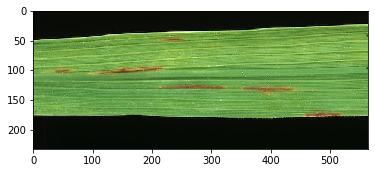

Original label: Brown spot, Prediction: Bacterial leaf blight


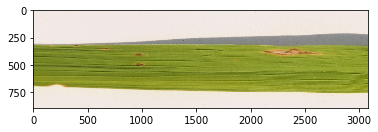

Original label: Leaf smut, Prediction: Bacterial leaf blight


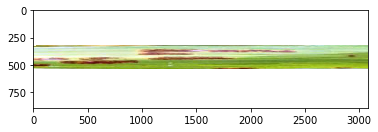

Original label: Leaf smut, Prediction: Brown spot


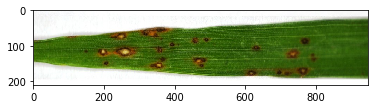

In [46]:
# Visualizing the misclassifications

for i in range(len(errors)):
    num = errors[i]
    print('Original label: {}, Prediction: {}'.format(test['Disease'][num], idx2labels[predictions[num]]))
    images = im.imread(test.Images[num])
    plt.imshow(images)
    plt.show()

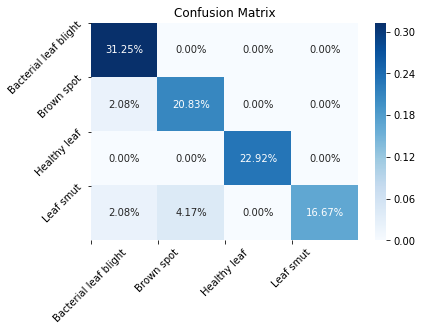

In [47]:
# Plotting a confusion matrix

cm = confusion_matrix(groundtruth, predictions)
sns.heatmap(cm/np.sum(cm), fmt='.2%', cmap='Blues', annot=True)
tick_marks = np.arange(len(idx2labels))
plt.xticks(tick_marks, idx2labels, rotation=45)
plt.yticks(tick_marks, idx2labels, rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [48]:
# Printing the image classification report

print(classification_report(groundtruth, predictions, target_names=idx2labels))

                       precision    recall  f1-score   support

Bacterial leaf blight       0.88      1.00      0.94        15
           Brown spot       0.83      0.91      0.87        11
         Healthy leaf       1.00      1.00      1.00        11
            Leaf smut       1.00      0.73      0.84        11

             accuracy                           0.92        48
            macro avg       0.93      0.91      0.91        48
         weighted avg       0.93      0.92      0.91        48

